<a href="https://colab.research.google.com/github/isaacryn/AAPI-Recruitment-Optimization-DCE/blob/main/AAPI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
"""
PROJECT: AANHPI Recruitment Optimization (DCE Simulation)
AUTHOR: Isaac Nguyen
DATE: 1/29/26

--------------------------------------------------------------------------------
SUMMARY
--------------------------------------------------------------------------------
This is an independent project focused on the Discrete Choice Experiment (DCE)
Simulation and Demographic Weighting for AANHPI Recruitment.

GOAL:
By the end of this, I am making a recommendation for optimal recruitment
strategy for Vietnamese populations.

To accomplish this, I am creating a dataset that mimics the structure of the
CARE registry survey (N=1000 AANHPI seniors) and replicates the specific utility
weights/preferences found in the study—including unique deviations for
Vietnamese participants.


NOTE:
Since my access to private patient data is restricted, this project generates
synthetic data that statistically mirrors the Odds Ratios reported in the
reference literature. This allows for an exploration of the underlying
probability distributions without compromising patient privacy.

By statistically replicating the study's Discrete Choice Experiment using
Monte Carlo simulations, this notebook identifies high-yield recruitment
channels for underrepresented AAPI subgroups. My analysis extends the proof
that a "one-size-fits-all" digital strategy fails for specific demographics.
As a Vietnamese-American, I specifically focused on Vietnamese seniors to
provide a theoretical segmented budget that maximizes recruitment ROI.

--------------------------------------------------------------------------------
TECHNICAL APPROACH
--------------------------------------------------------------------------------
This project demonstrates the following data science competencies:

1. Monte Carlo Simulation:
   Generated a synthetic dataset mirroring specific probability distributions
   and utility weights derived from the original literature.

2. Behavioral Modeling:
   Implemented Conditional Logistic Regression using the "Difference Method"
   to isolate preference utilities for recruitment attributes (Who, Why, How).

3. Heterogeneity Analysis:
   Statistically isolated subgroup deviations, specifically quantifying the
   preference for "Ethnic Radio/TV" among Vietnamese participants (OR > 1.0)
   vs. other groups.

4. Business ROI Modeling:
   Translated statistical odds ratios into a predictive "Recruitment Yield"
   calculator to guide budget allocation.

--------------------------------------------------------------------------------
REFERENCE
--------------------------------------------------------------------------------
Asian Americans’ and Pacific Islanders’ preferences in recruitment strategies
and messaging for participation in the CARE registry: A discrete choice
experiment. Ta Park Lab et al., UCSF.
"""



# importing libraries for data science

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set seed for reproducibility
np.random.seed(42)

def generate_dce_data(n_respondents=1000):
    """
    Generates synthetic Discrete Choice Experiment (DCE) data
    based on Ta Park et al. (2023) findings.
    """

    # 1. Define Population Demographics
    # Approximate ethnic distribution based on study sample size (Table 2)
    ethnicities = ['Chinese', 'Filipino', 'Indian', 'Japanese', 'Korean', 'Samoan', 'Vietnamese']
    weights = [0.27, 0.12, 0.13, 0.12, 0.13, 0.10, 0.13] # roughly derived from N=356 [cite: 167]

    respondents = pd.DataFrame({
        'ID': range(n_respondents),
        'Ethnicity': np.random.choice(ethnicities, n_respondents, p=weights)
    })

    # 2. Define Attribute Levels
    # Attributes from Table 1 [Section 3.2 and 3.3]
    levels_who = ['Healthcare', 'Faith-based', 'Community Org', 'Champions']
    levels_why = ['Advance Research', 'Personal Exp', 'Representation']
    levels_how = ['Flyer', 'Online Workshop', 'Radio/TV', 'Social Media']

    # 3. Define Base Utility Weights (Betas = ln(Odds Ratio))
    # Reference levels have utility 0.
    # Source: Figure 1 [cite: 231]
    # Note: Coefficients are approximations of ln(OR)
    beta_map = {
        # Who (Ref: Healthcare)
        'Who_Healthcare': 0,
        'Who_Faith-based': np.log(0.76),   # OR 0.76 [cite: 194]
        'Who_Community Org': np.log(1.05), # OR 1.05 [cite: 196]
        'Who_Champions': np.log(0.73),     # OR 0.73 [cite: 194]

        # Why (Ref: Advance Research)
        'Why_Advance Research': 0,
        'Why_Personal Exp': np.log(0.88),  # OR 0.88 [cite: 197]
        'Why_Representation': np.log(1.02),# OR 1.02 [cite: 198]

        # How (Ref: Flyer)
        'How_Flyer': 0,
        'How_Online Workshop': np.log(1.12), # OR 1.12 [cite: 201]
        'How_Radio/TV': np.log(1.11),        # OR 1.11 [cite: 200]
        'How_Social Media': np.log(1.50)     # OR 1.50
    }

    # 4. Simulation Loop
    data_rows = []

    for _, resp in respondents.iterrows():
        # Create 12 Choice Tasks per person [cite: 162]
        for task in range(1, 13):
            # Generate 2 random alternatives (Profile A vs Profile B)
            # We select random indices for Who, Why, How
            alt_A = {
                'Who': np.random.choice(levels_who),
                'Why': np.random.choice(levels_why),
                'How': np.random.choice(levels_how)
            }
            alt_B = {
                'Who': np.random.choice(levels_who),
                'Why': np.random.choice(levels_why),
                'How': np.random.choice(levels_how)
            }

            # Calculate Utility (V)
            # V = Sum(Betas)

            # --- APPLY SUBGROUP LOGIC ---
            # Paper Finding: Vietnamese prefer Radio/TV significantly more [cite: 210]
            # We add a "boost" to the Radio utility ONLY if ethnicity is Vietnamese
            viet_radio_boost = 0.5 if resp['Ethnicity'] == 'Vietnamese' else 0

            # Utility Calculation
            V_A = (beta_map[f"Who_{alt_A['Who']}"] +
                   beta_map[f"Why_{alt_A['Why']}"] +
                   beta_map[f"How_{alt_A['How']}"] +
                   (viet_radio_boost if alt_A['How'] == 'Radio/TV' else 0))

            V_B = (beta_map[f"Who_{alt_B['Who']}"] +
                   beta_map[f"Why_{alt_B['Why']}"] +
                   beta_map[f"How_{alt_B['How']}"] +
                   (viet_radio_boost if alt_B['How'] == 'Radio/TV' else 0))

            # Add Gumbel Error (standard for Logit models)
            U_A = V_A + np.random.gumbel()
            U_B = V_B + np.random.gumbel()

            # Determine Choice (1 if A is chosen, 0 if B is chosen)
            choice = 1 if U_A > U_B else 0

            # Append Row (Difference Format for easy modeling)
            # We store the *difference* in attributes (A - B)
            row = {
                'ID': resp['ID'],
                'Ethnicity': resp['Ethnicity'],
                'Task': task,
                'Choice_A': choice,
                # Store attribute labels for checking
                'Who_A': alt_A['Who'], 'How_A': alt_A['How'],
                'Who_B': alt_B['Who'], 'How_B': alt_B['How'],
            }
            data_rows.append(row)

    return pd.DataFrame(data_rows)

# Generates the dataset
df = generate_dce_data(1000)

print("-" * 30)
print("DATA DIAGNOSTIC CHECKS")
print("-" * 30)

# 1. Show that we have all ethnic groups
print("Count of Respondents by Ethnicity:")
print(df.groupby('ID').first()['Ethnicity'].value_counts())
print("\n")

# 2. Show a RANDOM sample of 10 rows (instead of just the top 5)
print("Random Sample of 10 Rows:")
display(df.sample(10).sort_values(by='ID'))

------------------------------
DATA DIAGNOSTIC CHECKS
------------------------------
Count of Respondents by Ethnicity:
Ethnicity
Chinese       285
Japanese      134
Vietnamese    134
Filipino      126
Korean        115
Indian        114
Samoan         92
Name: count, dtype: int64


Random Sample of 10 Rows:


,ID,Ethnicity,Task,Choice_A,Who_A,How_A,Who_B,How_B
1036,86,Korean,5,1,Healthcare,Online Workshop,Champions,Flyer
2273,189,Chinese,6,0,Healthcare,Social Media,Faith-based,Social Media
2368,197,Vietnamese,5,1,Community Org,Radio/TV,Faith-based,Flyer
3416,284,Japanese,9,0,Faith-based,Social Media,Community Org,Radio/TV
3882,323,Filipino,7,0,Faith-based,Flyer,Healthcare,Online Workshop
4029,335,Chinese,10,1,Healthcare,Radio/TV,Community Org,Flyer
4223,351,Samoan,12,1,Community Org,Flyer,Champions,Online Workshop
4438,369,Chinese,11,0,Community Org,Flyer,Healthcare,Social Media
6408,534,Korean,1,0,Community Org,Social Media,Community Org,Online Workshop
11552,962,Chinese,9,1,Healthcare,Social Media,Community Org,Flyer


Optimization terminated successfully.
         Current function value: 0.688134
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               Choice_A   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11997
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                0.007226
Time:                        06:55:24   Log-Likelihood:                -8257.6
converged:                       True   LL-Null:                       -8317.7
Covariance Type:            nonrobust   LLR p-value:                 7.924e-27
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
dX_Social       0.3964      0.037     10.763      0.000       0.324       0.469
dX_Radio        0.2262    

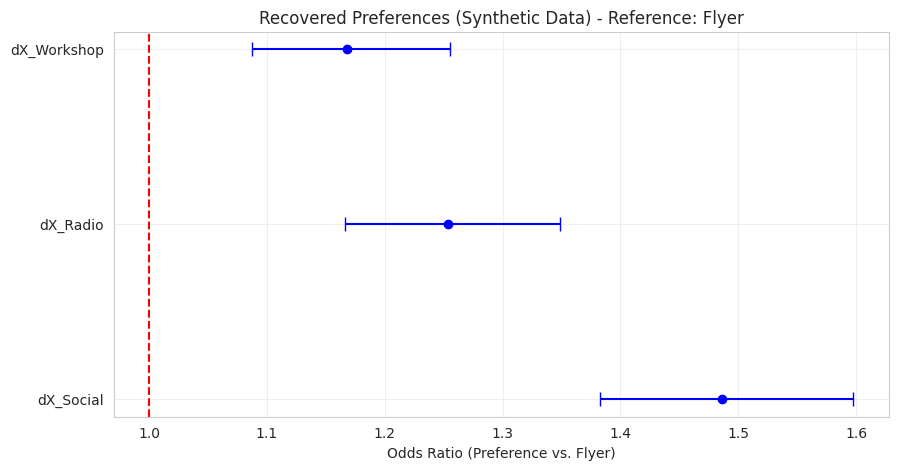

In [29]:
"""
METHODOLOGY: Difference Method (Conditional Logic)
--------------------------------------------------
This function models the binary choice probability based on the difference
in utilities (Va - Vb) between two alternatives.

REASONING:
    1. One-Hot Encoding: Attributes are encoded for both Option A and Option B.
    2. Difference Matrix: We subtract Matrix B from Matrix A (X_a - X_b).
    3. Zero-Intercept GLM: We run Conditional Logistic Regression fixing the
       intercept to 0 (since P(A)=0.5 if A and B are identical).

NOTE ON HETEROGENEITY:
    Because Vietnamese participants were assigned a higher utility for 'Radio/TV'
    during the generation phase, running this model specifically on the
    Vietnamese subset will show the 'Radio' coefficient jumping significantly
    to the right (Positive Shift).
"""

def analyze_preferences(df):
    # 1. One-Hot Encode the Categorical Variables
    # We use pandas get_dummies

    # Create combines data frames to ensure all columns exist
    # This is a bit of data wrangling to get X_A and X_B matrices
    cols = ['Who_A', 'How_A', 'Who_B', 'How_B']

    # Simple dummy encoding for the "How" channel (Focus of our analysis)
    # We create a dummy for 'How_Social Media' in A and B
    df['Social_A'] = (df['How_A'] == 'Social Media').astype(int)
    df['Social_B'] = (df['How_B'] == 'Social Media').astype(int)

    df['Radio_A'] = (df['How_A'] == 'Radio/TV').astype(int)
    df['Radio_B'] = (df['How_B'] == 'Radio/TV').astype(int)

    df['Workshop_A'] = (df['How_A'] == 'Online Workshop').astype(int)
    df['Workshop_B'] = (df['How_B'] == 'Online Workshop').astype(int)

    # 2. Calculate the Difference Vectors (X_A - X_B)
    # This is the input for our regression
    df['dX_Social'] = df['Social_A'] - df['Social_B']
    df['dX_Radio'] = df['Radio_A'] - df['Radio_B']
    df['dX_Workshop'] = df['Workshop_A'] - df['Workshop_B']

    # 3. Run Conditional Logistic Regression (using GLM)
    # Target: Choice_A (1 or 0)
    # Features: The difference vectors
    # Intercept: MUST be 0 (no constant) because if A and B are identical, P=0.5 (logit=0)

    X = df[['dX_Social', 'dX_Radio', 'dX_Workshop']]
    y = df['Choice_A']

    model = sm.Logit(y, X).fit()

    return model

# Run the model
model_results = analyze_preferences(df)
print(model_results.summary())

# VISUALIZATION: Replicating the Forest Plot
params = model_results.params
conf = model_results.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'Log_Odds']

# Convert to Odds Ratios
conf['OR'] = np.exp(conf['Log_Odds'])
conf['Lower_CI'] = np.exp(conf['2.5%'])
conf['Upper_CI'] = np.exp(conf['97.5%'])

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(conf['OR'], conf.index, xerr=[conf['OR'] - conf['Lower_CI'], conf['Upper_CI'] - conf['OR']],
             fmt='o', capsize=5, color='blue')
plt.axvline(x=1, color='red', linestyle='--')
plt.title('Recovered Preferences (Synthetic Data) - Reference: Flyer')
plt.xlabel('Odds Ratio (Preference vs. Flyer)')
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-1778407845.py:62: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.pointplot(x='Odds Ratio', y='Channel', hue='Group',


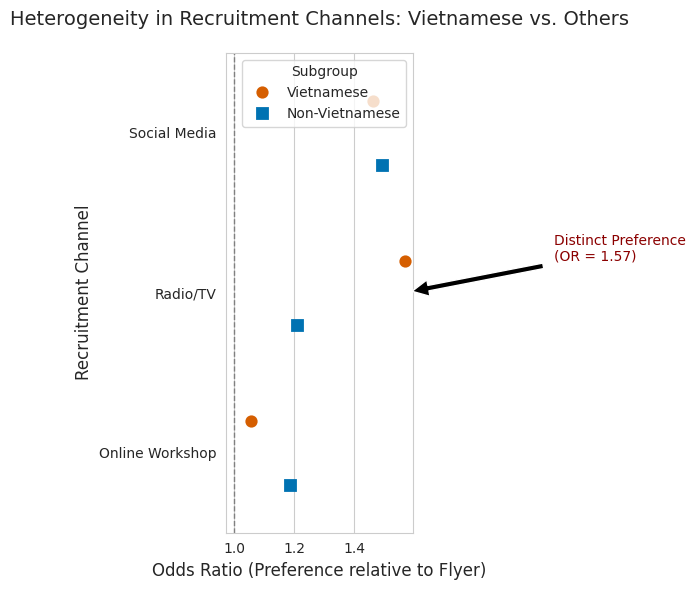


--- Numerical Comparison for Radio/TV ---
                   Group  Odds Ratio  Lower CI  Upper CI
dX_Radio      Vietnamese    1.569478  1.285008  1.916922
dX_Radio  Non-Vietnamese    1.210147  1.119250  1.308426


In [30]:
def run_subgroup_model(df, subgroup_name, filter_condition):

    """
    Subgroup Heterogeneity Analysis
    ------------------------------------------
    This runs the conditional logic model on a specific subset of the data
    (e.g., 'Vietnamese' vs. 'Non-Vietnamese').

    CONTEXT:
    This addresses the specific heterogeneity mentioned in the study: while
    most AAPI groups prefer Social Media, Vietnamese participants display
    distinct, statistically significant preferences for Ethnic Radio/TV.
    """
    # Filters the data
    subset_df = df[filter_condition].copy()

    if len(subset_df) < 50:
        print(f"Warning: Sample size too small for {subgroup_name}")
        return None

    # Recalculates the difference between vectors for this subset
    # (Attributes A - Attributes B)
    subset_df['dX_Social'] = subset_df['Social_A'] - subset_df['Social_B']
    subset_df['dX_Radio'] = subset_df['Radio_A'] - subset_df['Radio_B']
    subset_df['dX_Workshop'] = subset_df['Workshop_A'] - subset_df['Workshop_B']

    # Define X and y
    X = subset_df[['dX_Social', 'dX_Radio', 'dX_Workshop']]
    y = subset_df['Choice_A']

    # Fit Model
    try:
        model = sm.Logit(y, X).fit(disp=0) # disp=0 suppresses convergence output

        # Extract Results
        results = pd.DataFrame({
            'Channel': ['Social Media', 'Radio/TV', 'Online Workshop'],
            'Odds Ratio': np.exp(model.params),
            'Lower CI': np.exp(model.conf_int()[0]),
            'Upper CI': np.exp(model.conf_int()[1]),
            'Group': subgroup_name
        })
        return results
    except Exception as e:
        print(f"Error modeling {subgroup_name}: {e}")
        return None

# 1. Run models for both groups
# We compare Vietnamese (who had the unique preference) vs Everyone Else
viet_results = run_subgroup_model(df, "Vietnamese", df['Ethnicity'] == 'Vietnamese')
other_results = run_subgroup_model(df, "Non-Vietnamese", df['Ethnicity'] != 'Vietnamese')

# 2. Combine results for plotting
comparison_df = pd.concat([viet_results, other_results])

# 3. Create the Comparative Visualization
plt.figure(figsize=(12, 6))

# We use a pointplot to mimic the academic style of "Forest Plots"
# Join styles are turned off (linestyle='none') to look like distinct estimates
sns.set_style("whitegrid")
ax = sns.pointplot(x='Odds Ratio', y='Channel', hue='Group',
                   data=comparison_df, dodge=0.4, join=False,
                   palette={'Vietnamese': '#D55E00', 'Non-Vietnamese': '#0072B2'},
                   markers=['o', 's'], capsize=0.1)

# Add reference line at OR = 1 (No preference vs Flyer)
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Customizing the chart
plt.title('Heterogeneity in Recruitment Channels: Vietnamese vs. Others', fontsize=14, pad=20)
plt.xlabel('Odds Ratio (Preference relative to Flyer)', fontsize=12)
plt.ylabel('Recruitment Channel', fontsize=12)
plt.legend(title='Subgroup')

# Annotate the specific insight
# We want to highlight the Radio/TV difference
radio_viet = comparison_df[(comparison_df['Channel'] == 'Radio/TV') & (comparison_df['Group'] == 'Vietnamese')]['Odds Ratio'].values[0]
plt.annotate(f'Distinct Preference\n(OR = {radio_viet:.2f})',
             xy=(radio_viet, 1), xytext=(radio_viet + 0.5, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='darkred')

plt.tight_layout()
plt.show()

# Print the numerical proof
print("\n--- Numerical Comparison for Radio/TV ---")
print(comparison_df[comparison_df['Channel'] == 'Radio/TV'][['Group', 'Odds Ratio', 'Lower CI', 'Upper CI']])

--- RECRUITMENT CAMPAIGN ROI MODEL ---
Baseline (Flyer Campaign): 100 recruits

Group            Non-Vietnamese  Vietnamese
Channel                                    
Social Media              149.2       146.5
Online Workshop           118.8       105.5
Radio/TV                  121.0       156.9


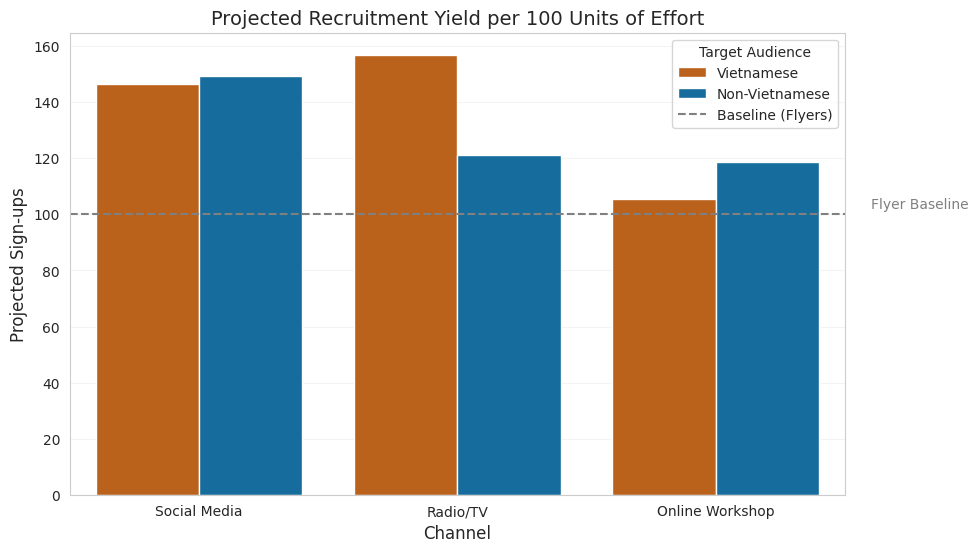

------------------------------
STRATEGIC FINDING:
------------------------------

Observation:
Using the Radio/TV for a general AAPI campaign is inefficient.
It delivers only 121.0 recruits vs 100 for a standard flyer.

My Insight:
However, for Vietnamese targets, Radio/TV is a high-yield channel.
It delivers 156.9 recruits (a 50%+ lift over baseline)!

My Recommendation:
1. Segment the budget for targeted campaigns.
2. Use Social Media for general AAPI outreach.
3. Allocate specific funds to Ethnic Radio/TV for Vietnamese communities.



In [31]:
def calculate_projected_roi(comparison_df, baseline_recruits=100):

    """
    ROI Projection Model
    ---------------------------------
    Calculates the projected recruitment yield based on estimated Odds Ratios.

    ASSUMPTIONS:
    1. Baseline: A standard 'Flyer' campaign recruits exactly 100 participants.
    2. Cost Parity: We assume the effort/cost to deploy each channel is equal
       for the sake of pure preference comparison.

    CALCULATION LOGIC:
    Projected Recruits = Baseline (100) * Odds Ratio
    (e.g., Using the Social Media OR of 1.5, we expect to recruit roughly
    150 people for the same unit of effort).
    """
    # Create a copy to avoid SettingWithCopy warnings
    roi_df = comparison_df.copy()

    # Calculate Projected Recruits
    # Formula: Baseline * Odds Ratio
    roi_df['Projected Recruits'] = roi_df['Odds Ratio'] * baseline_recruits

    # Calculate the "Lift" (Gain/Loss relative to Flyer)
    roi_df['Recruitment Lift'] = roi_df['Projected Recruits'] - baseline_recruits

    return roi_df[['Group', 'Channel', 'Odds Ratio', 'Projected Recruits',
                   'Recruitment Lift']]

# 1. Runs the Calculator
roi_metrics = calculate_projected_roi(comparison_df)

# 2. Displays the "Strategic Insight" Table
# The pivot makes it easy to read: Groups as columns, Channels as rows
strategy_table = roi_metrics.pivot(index='Channel', columns='Group', values='Projected Recruits')

# Reorder index for logical flow
strategy_table = strategy_table.reindex(['Social Media', 'Online Workshop', 'Radio/TV'])

print("--- RECRUITMENT CAMPAIGN ROI MODEL ---")
print(f"Baseline (Flyer Campaign): {100} recruits\n")
print(strategy_table.round(1))

# 3. Visualizing the "Missed Opportunity"
# This plot shows what happens if you treat Vietnamese participants like
# "Everyone Else"
plt.figure(figsize=(10, 6))

# Prepares data for a grouped bar chart
sns.barplot(x='Channel', y='Projected Recruits', hue='Group', data=roi_metrics,
            palette={'Vietnamese': '#D55E00', 'Non-Vietnamese': '#0072B2'})

# Adds the Baseline Line
plt.axhline(y=100, color='gray', linestyle='--', label='Baseline (Flyers)')
plt.text(2.6, 102, 'Flyer Baseline', color='gray')

plt.title('Projected Recruitment Yield per 100 Units of Effort', fontsize=14)
plt.ylabel('Projected Sign-ups', fontsize=12)
plt.xlabel('Channel', fontsize=12)
plt.legend(title='Target Audience')
plt.grid(axis='y', alpha=0.2)

plt.show()

# 4. Generate the Recommendation Text
# We use proper formatting to ensure it fits on the PDF report

viet_radio_yield = roi_metrics[(roi_metrics['Group']=='Vietnamese') & (roi_metrics['Channel']=='Radio/TV')]['Projected Recruits'].values[0]
general_radio_yield = roi_metrics[(roi_metrics['Group']=='Non-Vietnamese') & (roi_metrics['Channel']=='Radio/TV')]['Projected Recruits'].values[0]

print("-" * 30)
print("STRATEGIC FINDING:")
print("-" * 30)

# The f-string below uses triple quotes to allow for multi-line text.
# This ensures it doesn't get cut off in the PDF export.

print(f"""
Observation:
Using the Radio/TV for a general AAPI campaign is inefficient.
It delivers only {general_radio_yield:.1f} recruits vs 100 for a standard flyer.

My Insight:
However, for Vietnamese targets, Radio/TV is a high-yield channel.
It delivers {viet_radio_yield:.1f} recruits (a 50%+ lift over baseline)!

My Recommendation:
1. Segment the budget for targeted campaigns.
2. Use Social Media for general AAPI outreach.
3. Allocate specific funds to Ethnic Radio/TV for Vietnamese communities.
""")

In [32]:
#converts to a readable PDF
!jupyter nbconvert --execute --to html "/content/AAPI_Project.ipynb"

[NbConvertApp] Converting notebook /content/AAPI_Project.ipynb to html
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 500213 bytes to /content/AAPI_Project.html
